In [1]:
import os
import json
from glob import glob
from matplotlib.colors import ListedColormap
import numpy as np
import tifffile
from FSD.utils import extract_data, visualize, invert_one_hot
from FSD.fsd import process, reconstruct_label_mask

### Download Data

Images and corresponding instance segmentations (all of type `*.tif`) should be respectively present in sub-directories `images` and `masks`, which can be present at any location on your workstation, pointed to by the variables `data_dir` and `project_name`. 


In [2]:
data_dir = '../../../data'
project_name = 'BBBC020'

For the `BBBC020` dataset, we firstly download the data from an external url in the following cell.


In [3]:
# extract_data(
#     zip_url = 'https://github.com/lmanan/FSD/releases/download/v0.0.1/BBBC020.zip',
#     data_dir = data_dir,
#     project_name = project_name,
# )

### Investigate some of these images and corresponding instance segmentation masks

Load a `glasbey` style color map

In [4]:
new_cmp= np.load('../../../cmaps/cmap_60.npy')
new_cmp = ListedColormap(new_cmp)

In [5]:
%matplotlib inline
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'download', 'images','*.TIF')))
mask_file_names = sorted(glob(os.path.join(data_dir, project_name, 'download', 'masks','*.tif')))

Change the `index` parameter to visualize other images and masks. There are, in total, $20$ images and corresponding masks.

Image filename is jw-24h 1_c1.TIF and index is 10


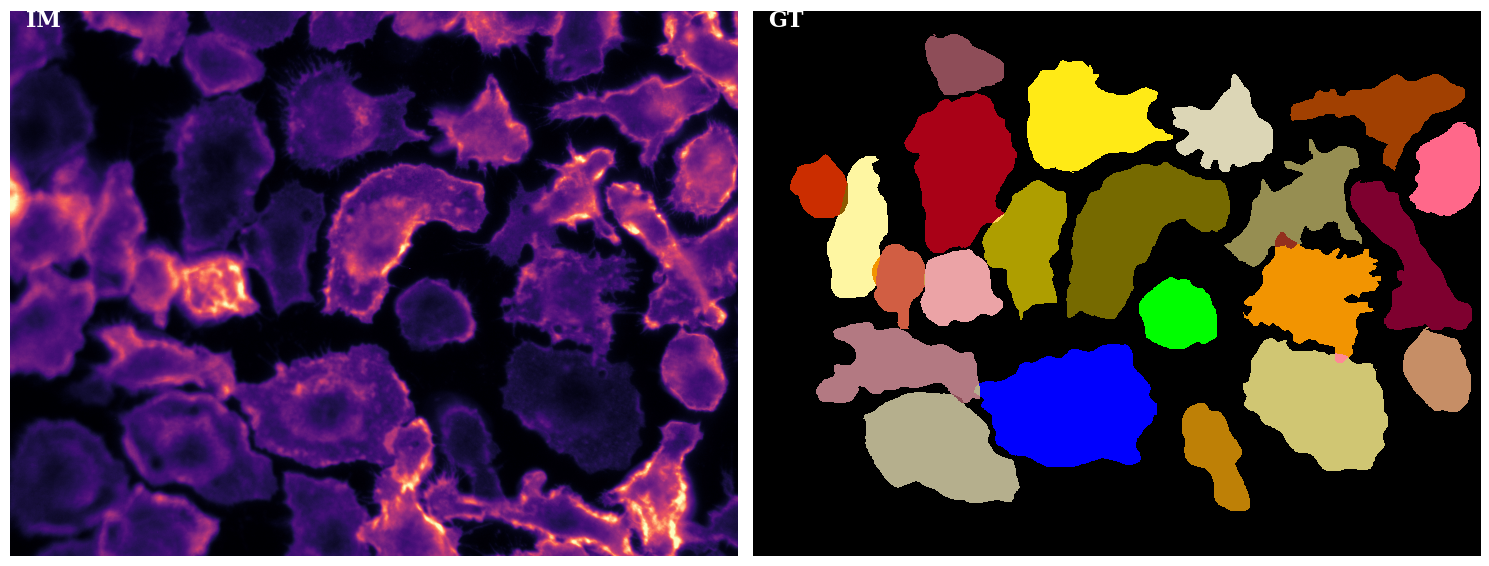

In [6]:
index = 10
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
image = tifffile.imread(image_file_names[index])
label_mask = tifffile.imread(mask_file_names[index])
visualize(image = image, ground_truth = invert_one_hot(label_mask), new_cmp = new_cmp)


### Convert shapes to Fourier Shape Descriptor (FSD) representations

We would like to study if there are any classes of diverse morphologies in this data-set. The task is to develop an analysis pipeline to retrieve and quantitatively characterize these morphology groups. <br>For this purpose, we use the `Fourier Shape Descriptor (FSD)` representation. This shape representation is obtained by going around the contour of each object one pixel at a time, storing the x and y coordinates of these boundary pixels, then performing a fourier analysis and finally investigating the obtained fourier coefficients. 

We process the complete available dataset through the `process` function. 

In [7]:
process(dir_name= os.path.join(data_dir, project_name, 'download'), fsd_dir_name = 'fsd/')

100%|███████████████████████████████████████████| 20/20 [03:03<00:00,  9.15s/it]


Now, that the frequency components are saved, we can investigate the fidelity of reconstruction for any arbitrary label mask. <br>
Change the `index` parameter to visualize other images and masks. There are, in total, 20 images and corresponding masks.<br>
Adjust the number of frequencies (`num_frequencies`) you would like to consider while reconstructing the shape.

In [7]:
index = 10
num_frequencies = 50

Image filename is jw-24h 1_c1.TIF and index is 10


/home/manan/Softwares/anaconda3/envs/FSDEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


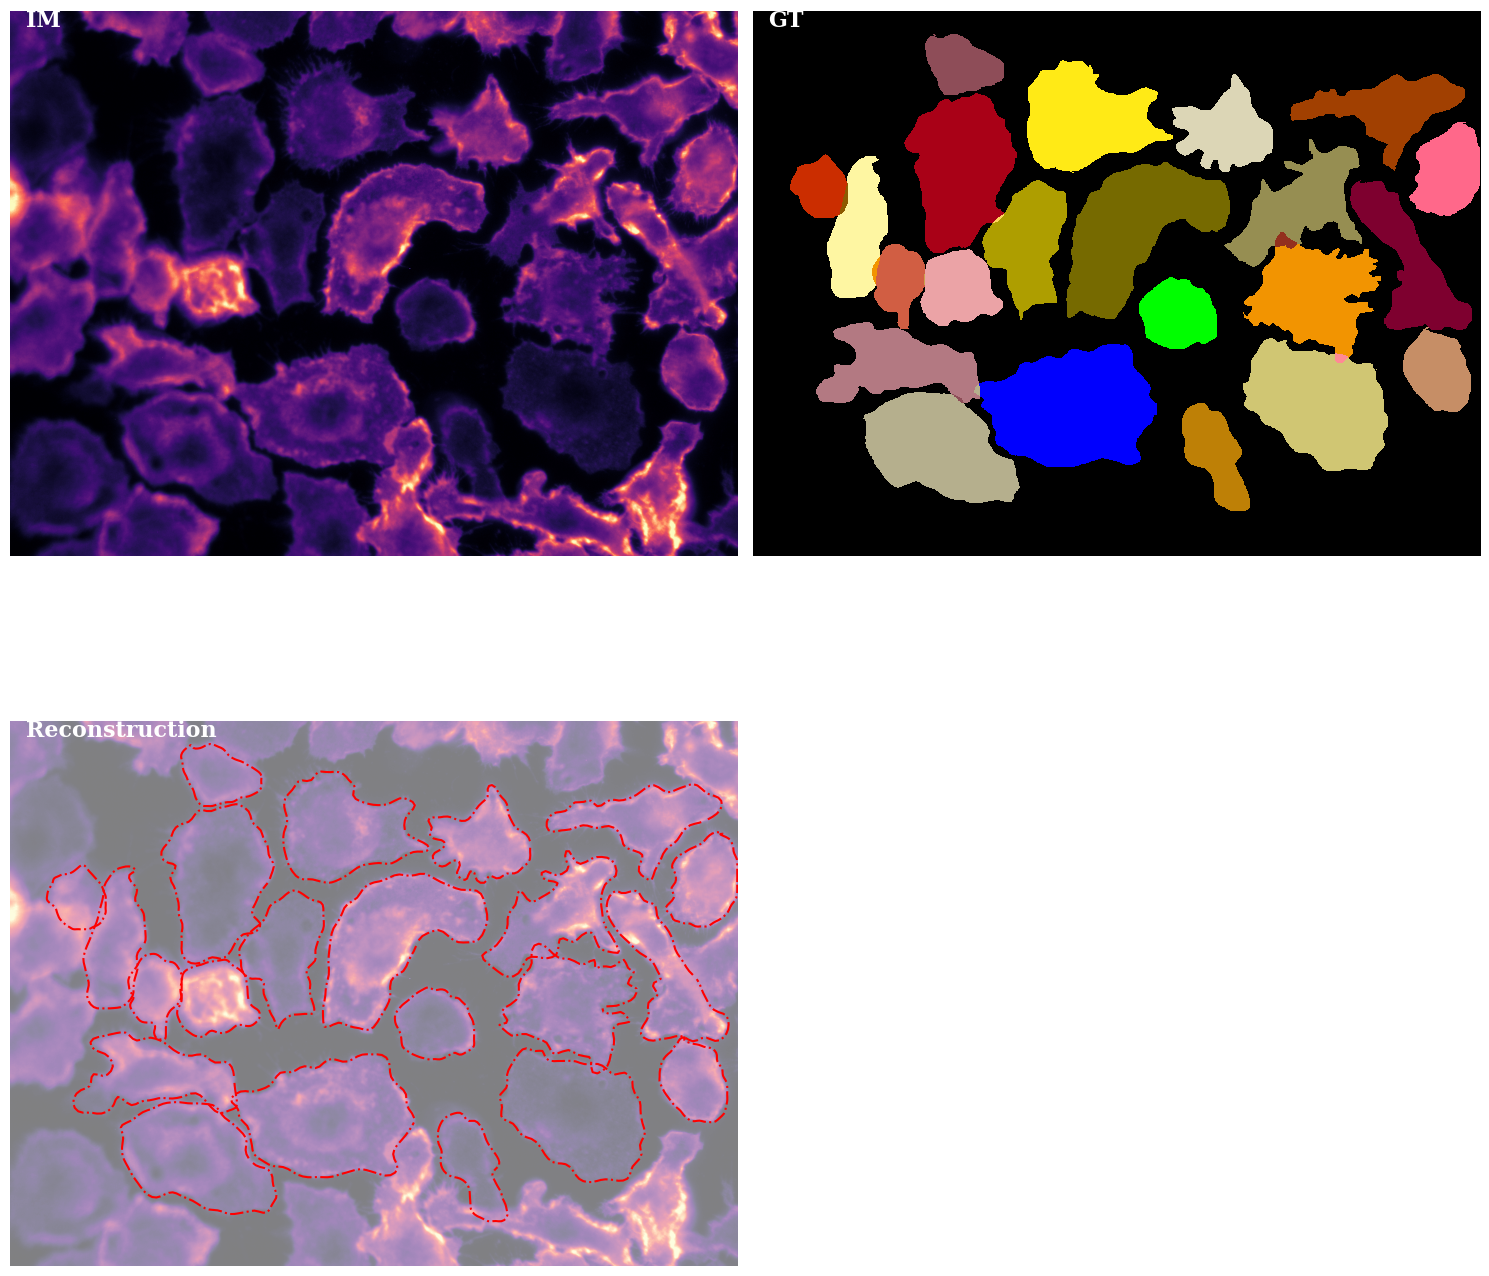

In [8]:
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
reconstruct_label_mask(im_path = image_file_names[index], 
                       label_path = mask_file_names[index], 
                       fsd_dir_name= os.path.join(data_dir, project_name, 'download', 'fsd'), 
                       num_frequencies= num_frequencies, new_cmp = new_cmp)

In [60]:
from FSD.fsd import get_sequential_boundary_pixels, perform_idft
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy

In [61]:
im = label_mask[0]
y, x =np.where(im==255)
ym, xm = np.mean(y), np.mean(x)
yb, xb = get_sequential_boundary_pixels(im, int(ym), int(xm), mode='outer')

In [62]:
X = 1 / len(xb) * scipy.fft.fft(xb)
Y = 1 / len(yb) * scipy.fft.fft(yb)

In [75]:
M = 100
x_recon = perform_idft(X, num_frequencies=M, number_of_points=100)
y_recon = perform_idft(Y, num_frequencies=M, number_of_points=100)

In [76]:
error1 = scipy.spatial.distance.directed_hausdorff(np.real(np.vstack((x_recon, y_recon)).transpose()), 
                                          np.real(np.vstack((xb, yb)).transpose()))[0]

In [77]:
print(error1)

0.7872388569960627


In [80]:
y_recon

[(579.983248299318+0.035342911735327276j),
 (575.7166301527361-0.03534291173532346j),
 (571.3206325836721+0.03534291173532603j),
 (567.4084392675198-0.03534291173532814j),
 (563.8794105621529+0.035342911735326665j),
 (559.3591829910918-0.035342911735326374j),
 (555.2286442516+0.03534291173532707j),
 (550.7303440365159-0.03534291173532528j),
 (546.648206852346+0.03534291173532683j),
 (542.0033123254002-0.03534291173532464j),
 (538.9880435554162+0.03534291173532714j),
 (535.708899650406-0.03534291173532493j),
 (531.9330353795567+0.03534291173532582j),
 (528.7282771479756-0.035342911735326256j),
 (527.9063772056402+0.03534291173532712j),
 (527.9736149444147-0.035342911735325416j),
 (525.9508624874717+0.035342911735325076j),
 (523.6438894726766-0.03534291173532451j),
 (519.4349614231995+0.03534291173532552j),
 (515.1554636988459-0.035342911735326j),
 (512.8004977925763+0.035342911735326554j),
 (511.968509829181-0.035342911735326055j),
 (512.0265417991953+0.03534291173532584j),
 (512.075867

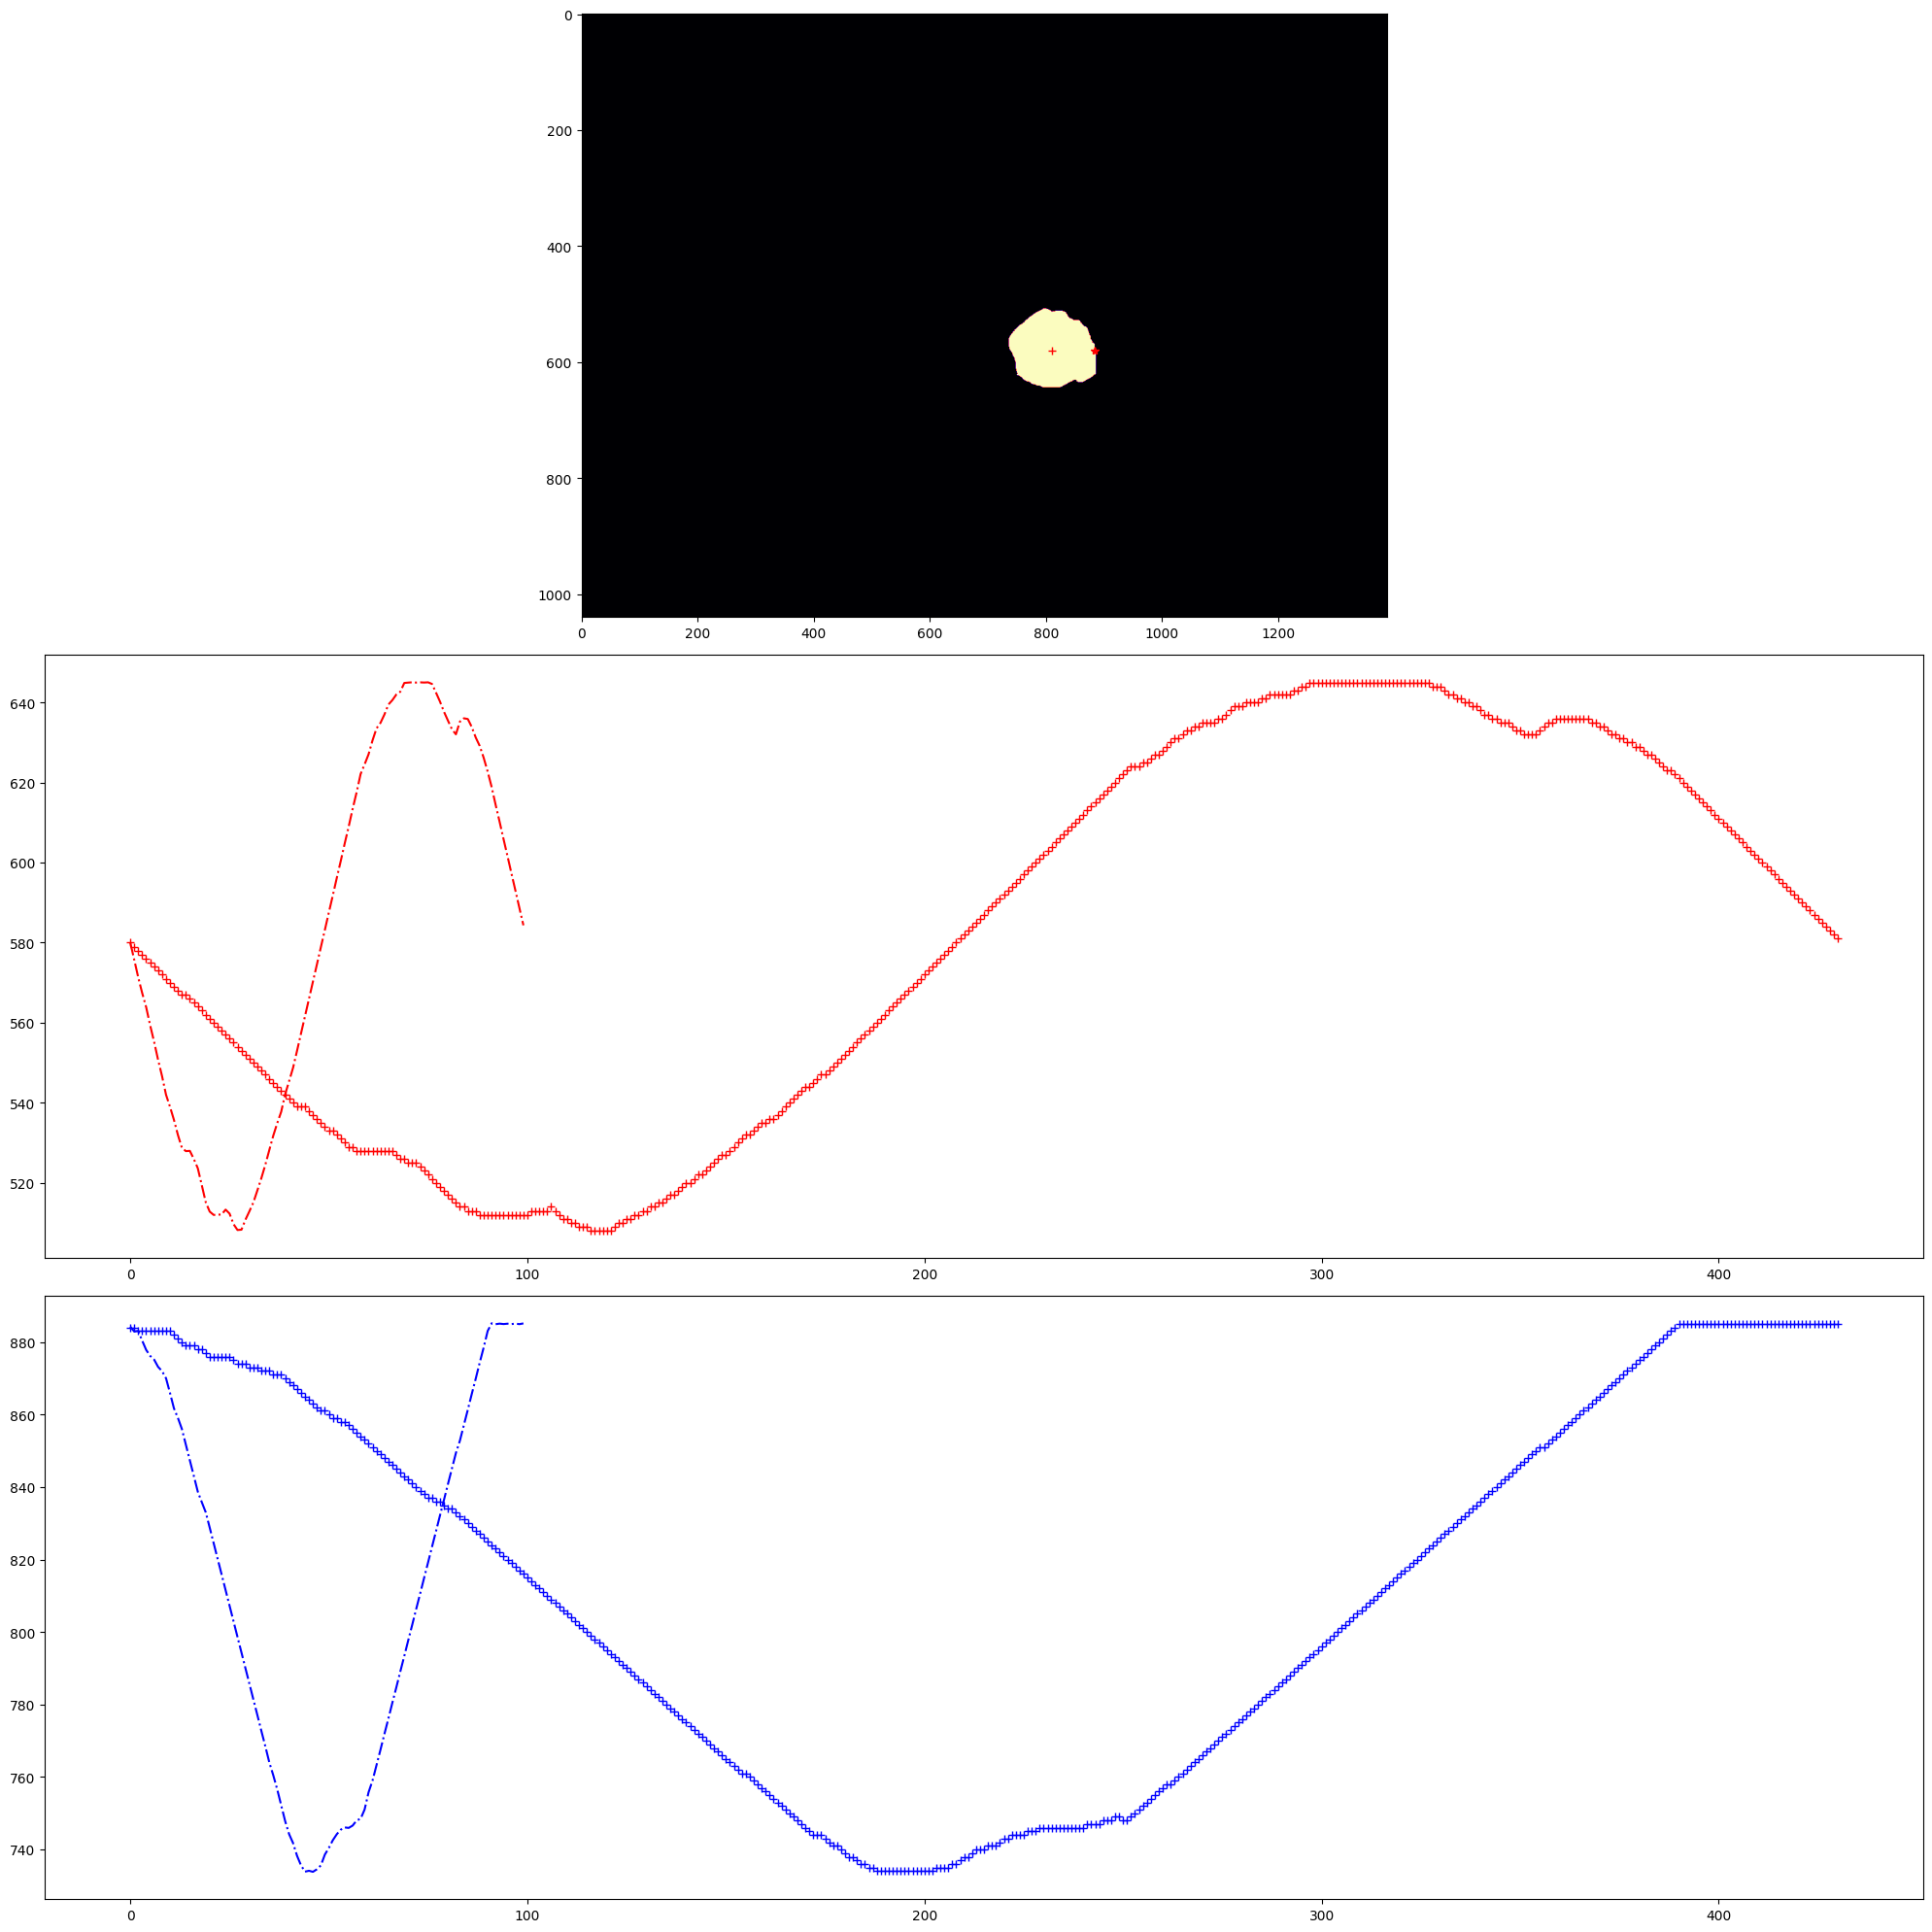

In [78]:
fig = plt.figure(constrained_layout=False, figsize=(20, 20))
spec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
# first row
ax1 = fig.add_subplot(spec[0, 0])
plt.imshow(im, cmap='magma')
plt.plot(xm, ym, 'r+')
plt.plot(xb[0], yb[0], 'r*')

# second row
ax4 = fig.add_subplot(spec[1, 0])
plt.plot(yb, 'r+')
plt.plot(y_recon, 'r-.')

# third row
ax7 = fig.add_subplot(spec[2, 0])
plt.plot(xb, 'b+')
plt.plot(x_recon, 'b-.')

plt.tight_layout()
plt.show()

In [150]:
ym

542.2067353451655

In [151]:
xm

1069.0114215329488

In [153]:
Y1

array([541.42638623 +0.j        ,   5.813543  +47.89184937j,
        -3.96538062 -4.89540724j, ...,  -3.87341049 -0.92489555j,
        -3.96538062 +4.89540724j,   5.813543  -47.89184937j])

In [154]:
X1

array([1082.61567878 +0.j        ,   56.54032349-10.39329986j,
        -12.77161168 +1.74311079j, ...,   -4.11180739 +3.18638151j,
        -12.77161168 -1.74311079j,   56.54032349+10.39329986j])